# Transport Network Properties

## 0 Preliminaries

In [1]:
import os
import warnings

import contextily as cx
import geopandas as gpd
import igraph as ig
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import osmnx as ox
import pandas as pd
from matplotlib.axes import Axes
from matplotlib.colors import LogNorm
from matplotlib.ticker import FuncFormatter, LogLocator

warnings.filterwarnings("ignore")

In [2]:
BASE_PATH = "./outputs"
GDF_BOUNDS = gpd.read_file(os.path.join(BASE_PATH, "boundaries.gpkg"))
GRAPH_TRANSPORT = ox.load_graphml(os.path.join(BASE_PATH, "merged_network_simplified.graphml"))

## 1 Analyze node distribution

In [3]:
def plot_with_basemap(
    ax: Axes,
    title: str,
    filename: str = None,
    padding: float = 0.1,
    basemap: bool = True,
) -> None:
    if basemap:
        x_min, y_min, x_max, y_max = GDF_BOUNDS.total_bounds
        ax.set_xlim(x_min - padding, x_max + padding)
        ax.set_ylim(y_min - padding, y_max + padding)

        cx.add_basemap(
            ax,
            crs=GDF_BOUNDS.crs,
            source=cx.providers.CartoDB.Positron,
            attribution="",
        )

    ax.set_title(title)
    ax.set_axis_off()
    plt.tight_layout()

    if filename:
        filepath = os.path.join(BASE_PATH, filename)
        plt.savefig(filepath, dpi=300, bbox_inches="tight")

    plt.show()


def plot_choropleth(
    ax: Axes,
    gdf: gpd.GeoDataFrame,
    column: str,
    title: str,
    cmap: str,
    filename: str = None,
    basemap: bool = True,
    cbar: bool = True,
):
    data = gdf[column].replace(0, np.nan).dropna()
    vmin = max(data.min(), 1e-8)
    vmax = data.max()

    norm = LogNorm(vmin=vmin, vmax=vmax)

    formatter = FuncFormatter(lambda x, _: f"{x:.1e}")
    locator = LogLocator(base=10.0, numticks=3)

    legend_kwds = {
        "label": f"Log-Scaled Average {' '.join(column.split('_')).title()}",
        "orientation": "horizontal",
        "pad": 0.01,
        "shrink": 0.5,
        "format": formatter,
        "ticks": locator.tick_values(vmin, vmax),
    }

    gdf.plot(
        column=column,
        ax=ax,
        cmap=cmap,
        edgecolor="white",
        linewidth=0.5,
        legend=cbar,
        legend_kwds=legend_kwds,
        norm=norm,
    )

    plot_with_basemap(ax=ax, title=title, filename=filename, basemap=basemap)

In [4]:
gdf_nodes = ox.graph_to_gdfs(GRAPH_TRANSPORT, edges=False)[["geometry"]]
gdf_nodes = gpd.sjoin(gdf_nodes, GDF_BOUNDS, how="inner", predicate="within")
gdf_nodes = gdf_nodes.drop(columns=["index_right"])
gdf_nodes.head()

,geometry,town,province
osmid,,,
300744370,POINT (124.03376 11.76261),Esperanza,Masbate
300744933,POINT (124.06395 11.76468),Pio V. Corpus,Masbate
300744970,POINT (124.05778 11.86383),Pio V. Corpus,Masbate
300745522,POINT (123.90828 11.91029),Placer,Masbate
300746507,POINT (123.99164 11.96455),Cataingan,Masbate


In [15]:
def compute_node_counts_by_town(
    gdf_metrics: gpd.GeoDataFrame,
    gdf_nodes: gpd.GeoDataFrame,
    col: str = "node_count",
) -> pd.DataFrame:
    df_node_counts = gdf_nodes.groupby(["town"]).size().reset_index(name=col)
    return gdf_metrics.merge(df_node_counts, on=["town"], how="left")


gdf_metrics = compute_node_counts_by_town(GDF_BOUNDS.copy(), gdf_nodes)

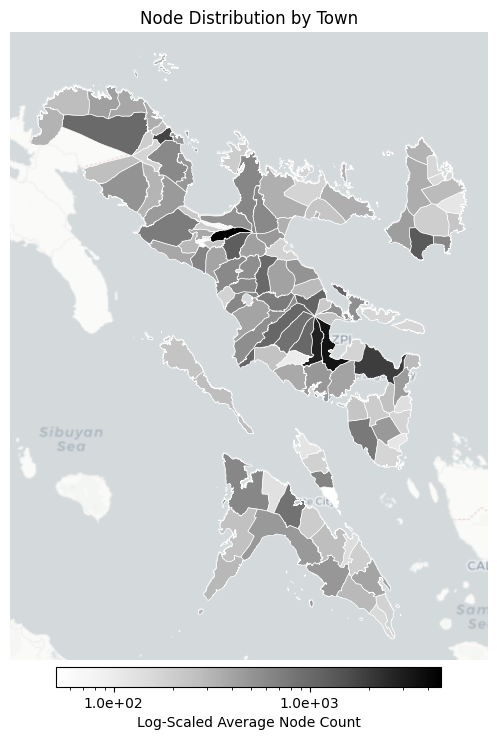

In [16]:
_, ax = plt.subplots(figsize=(8, 8))

plot_choropleth(
    ax=ax,
    gdf=gdf_metrics,
    column="node_count",
    title="Node Distribution by Town",
    cmap="Greys",
    filename="node_count_map.png",
)

## 2 Compute centrality metrics for all nodes

In [7]:
def networkx_to_igraph(nx_graph: nx.Graph) -> ig.Graph:
    nx_nodes = list(nx_graph.nodes)
    node_index = {node: idx for idx, node in enumerate(nx_nodes)}

    ig_edges = [(node_index[u], node_index[v]) for u, v in nx_graph.edges()]
    graph = ig.Graph(edges=ig_edges, directed=False)
    graph.vs["name"] = [str(n) for n in nx_nodes]

    return graph, list(node_index.keys())


graph_ig, node_index = networkx_to_igraph(GRAPH_TRANSPORT)

In [ ]:
degree_raw = graph_ig.degree()
closeness_raw = graph_ig.closeness(normalized=True)
betweenness_raw = graph_ig.betweenness()

n = graph_ig.vcount()
degree_norm = [d / (n - 1) for d in degree_raw]
betweenness_norm = [b / ((n - 1) * (n - 2)) if n > 2 else 0 for b in betweenness_raw]

centralities = {
    "osmid": node_index,
    "degree": degree_norm,
    "closeness": closeness_raw,
    "betweenness": betweenness_norm,
}

df_centrality = pd.DataFrame(centralities)
df_centrality.head()

,osmid,degree,closeness,betweenness
0,300744370,0.000053,0.003144,0.001964
1,300744933,0.000053,0.003096,0.001374
2,300744970,0.000053,0.003235,0.000093
3,300745522,0.000053,0.003578,0.001914
4,300746507,0.000053,0.003505,0.001660


In [9]:
df_centrality.to_csv(os.path.join(BASE_PATH, "node_metrics.csv"), index=False)

## 3 Compute average metrics for each town

In [10]:
def get_town_metrics(
    gdf_metrics: gpd.GeoDataFrame,
    gdf_nodes: gpd.GeoDataFrame,
    df_centrality: pd.DataFrame,
) -> gpd.GeoDataFrame:
    df_merged = pd.merge(gdf_nodes, df_centrality, on="osmid")
    agg_metrics = {"degree": "mean", "betweenness": "mean", "closeness": "mean"}
    df_town_metrics = df_merged.groupby(["town"]).agg(agg_metrics).reset_index()
    cols = ["town", "province", "degree", "betweenness", "closeness", "geometry"]
    return gdf_metrics.merge(df_town_metrics, on=["town"])[cols]


gdf_metrics = get_town_metrics(gdf_metrics, gdf_nodes, df_centrality)

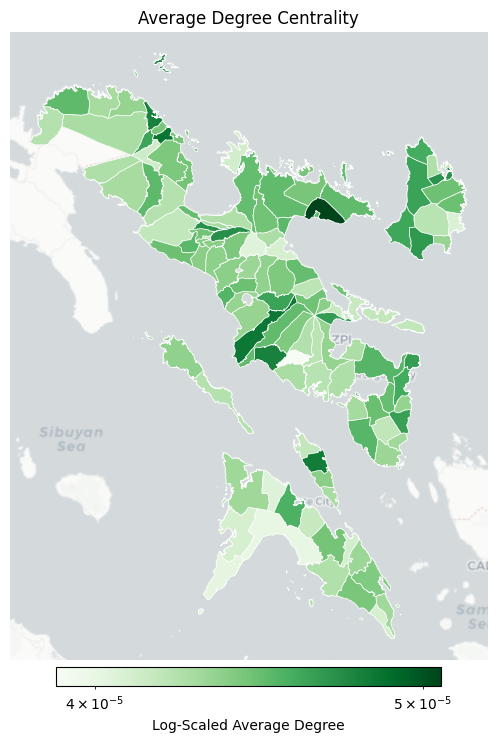

In [11]:
_, ax = plt.subplots(figsize=(8, 8))

plot_choropleth(
    ax=ax,
    gdf=gdf_metrics,
    column="degree",
    title="Average Degree Centrality",
    cmap="Greens",
    filename="degree_centrality_map.png",
)

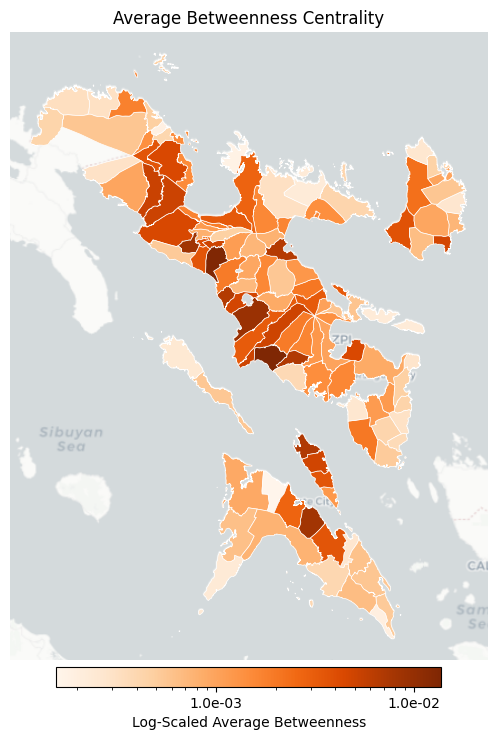

In [12]:
_, ax = plt.subplots(figsize=(8, 8))

plot_choropleth(
    ax=ax,
    gdf=gdf_metrics,
    column="betweenness",
    title="Average Betweenness Centrality",
    cmap="Oranges",
    filename="betweenness_centrality_map.png",
)

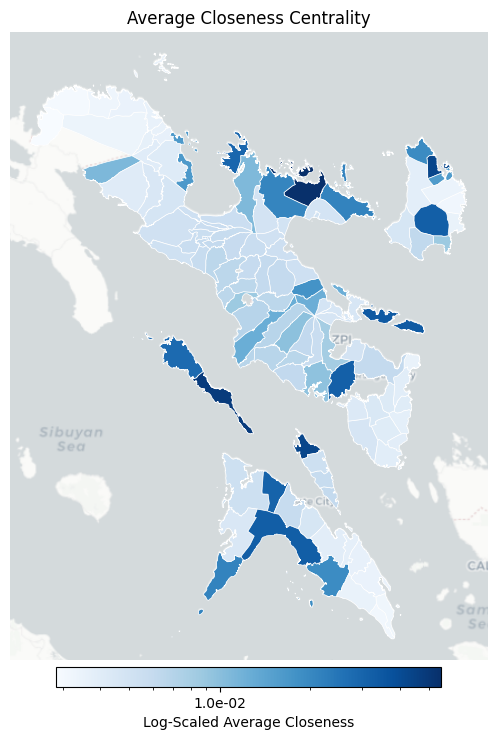

In [13]:
_, ax = plt.subplots(figsize=(8, 8))

plot_choropleth(
    ax=ax,
    gdf=gdf_metrics,
    column="closeness",
    title="Average Closeness Centrality",
    cmap="Blues",
    filename="closeness_centrality_map.png",
)